#### Setup Codes

In [1]:
%load_ext autoreload
%autoreload 2

##### Google Colab Setup

we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 'Test' folder and put all the files under 'example' folder, then 'Test/example'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Test/example'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'GIT/tutorials/utils/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

print(os.listdir(GOOGLE_DRIVE_PATH))

['__pycache__', 'for_knn.py', 'linear_classifier.py', 'custom_model_utils', 'Convolutional_Neural_Network', '_utils.py', 'save.py', '_word_processing.py', '_layers.py', 'enc2dec', 'data', 'models', 'colab_utils']


## Load MNIST Dataset

we will be working on the MNIST dataset, which has 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface.

In [4]:
import torchvision.transforms as T
import torchvision.datasets as dset
from torch.utils.data import DataLoader

In [ ]:
mnist_train = dset.MNIST('.', train=True, download=True, transform=T.ToTensor())
dataloader = DataLoader(mnist_train, batch_size=128, shuffle=True)

## AutoEncoder

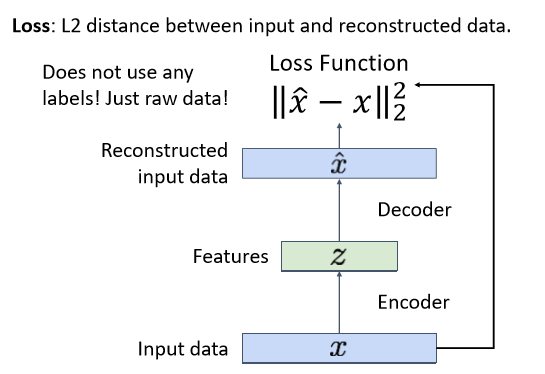

Unsupervised method for learning feature vectors from raw data x, without any labels.

*Idea* : Use the features to **reconstruct** the input data with a decoder `Autoencoding`. After training, throw away decoder and use encoder for a downstream task.

Autoencoder는 비지도 학습 알고리즘 중 하나로, 입력 데이터를 **reconstruct** 하는 모델이다. 인코더에서 데이터를 압축하고, 압축된 형태에서 원래 데이터를 복원하는 방법으로 학습한다. 이 과정에서 입력 데이터의 특징을 학습하게 된다. 훈련이 끝나면, 오토인코더의 디코더를 버리고, 인코더를 사용하여 **downstream task**를 수행할 수 있다. 인코더는 입력 데이터의 특성을 추출한 **latent**를 생성하므로, 이를 이용하여 다른 머신 러닝 모델에 입력으로 제공할 수 있다.

In [6]:
import torch
import torch.nn as nn

In [7]:
class AutoEncoder(nn.Module):
  def __init__(self, hidden_dim=258, latent_dim=128, img_size=(1, 28, 28)):
    super().__init__()

    C, H, W = img_size
    input_dim = C * H * W

    self.encoder = nn.Sequential(
        nn.Flatten(1, -1),
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, latent_dim),
        nn.ReLU(),
    )

    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim),
        nn.Sigmoid(),
        nn.Unflatten(dim=1, unflattened_size=img_size)
      )

  def forward(self, img):

    latent = self.encoder(img)
    output = self.decoder(latent)

    return output

### Train Net

In [8]:
def add_noise(images, noise_factor=0.5):
    noise = torch.randn_like(images) * noise_factor
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)

In [9]:
def train(model, criterion, optimizer, num_epochs=10, noisy=False):
  for epoch in range(num_epochs):

    total_losses = 0
    for inputs, _ in dataloader:

        if noisy:
          inputs = add_noise(inputs)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        total_losses += loss.item()

    print('Epoch [%d], Loss: %.4f' % (epoch + 1, total_losses / len(dataloader)))


In [10]:
import torch.optim as optim

In [11]:
ae = AutoEncoder(hidden_dim=256, latent_dim=128, img_size=(1, 28, 28))

optimizer = optim.Adam(ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()
train(ae, criterion, optimizer, num_epochs=10, noisy=False)

Epoch [1], Loss: 0.0523
Epoch [2], Loss: 0.0252
Epoch [3], Loss: 0.0195
Epoch [4], Loss: 0.0161
Epoch [5], Loss: 0.0138
Epoch [6], Loss: 0.0121
Epoch [7], Loss: 0.0109
Epoch [8], Loss: 0.0100
Epoch [9], Loss: 0.0093
Epoch [10], Loss: 0.0088


In [12]:
denoising_ae = AutoEncoder(hidden_dim=256, latent_dim=128, img_size=(1, 28, 28))

optimizer = optim.Adam(denoising_ae.parameters(), lr=1e-3)
criterion = nn.MSELoss()
train(denoising_ae, criterion, optimizer, num_epochs=10, noisy=True)

Epoch [1], Loss: 0.1051
Epoch [2], Loss: 0.0940
Epoch [3], Loss: 0.0898
Epoch [4], Loss: 0.0873
Epoch [5], Loss: 0.0857
Epoch [6], Loss: 0.0844
Epoch [7], Loss: 0.0836
Epoch [8], Loss: 0.0829
Epoch [9], Loss: 0.0823
Epoch [10], Loss: 0.0816


### Visulize results

In [13]:
import matplotlib.pyplot as plt

In [14]:
def visualize_results(model, noisy=False):
  with torch.no_grad():
    test_images, _ = next(iter(dataloader))

    if noisy:
      test_images = add_noise(test_images)

    output_image = model(test_images[:10])

    plt.figure(figsize=(20, 4))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(test_images[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(2, 10, i + 11)
        plt.imshow(output_image[i].numpy().squeeze(), cmap='gray')
        plt.axis('off')

    plt.show()

Vanila AutoEncoder


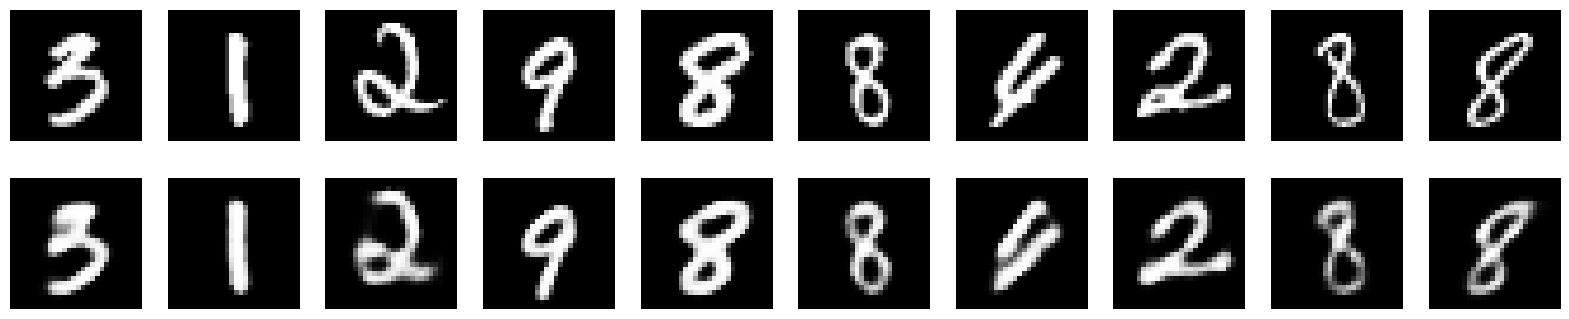

In [15]:
print(f"Vanila AutoEncoder")
visualize_results(ae)

Denoising AutoEncoder


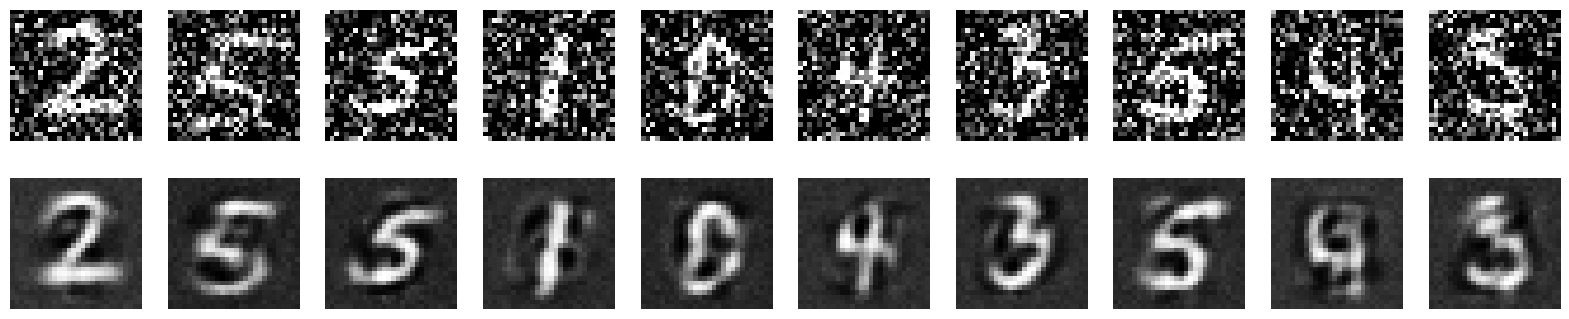

In [16]:
print(f"Denoising AutoEncoder")
visualize_results(denoising_ae, noisy=True)